In [1]:
import os
import copy
import pyperclip
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from functions.general_functions import pickleload
from functions.sparql_requests import sparql_select

pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 150)

plt.rcParams['font.family'] = 'Times New Roman'

# Results for RAG experiment

In [3]:
results = pd.concat([pickleload(f"data/with_assessment_{i}.pkl") for i in range(10)])
results["model_str"] = results["model_str"].replace(os.environ.get('FT_MODEL'), "mini-fine-tuned")
results["temperature"] = results["temperature"].apply(lambda x: round(x, 2))
results["few_shotting"] = results["template"] == "few_shotting"
 # = results["gt_results_from_graph_db"].apply(lambda x: set(x.iloc[:, 0]))

In [4]:
results["success_rate"] = results["success_level"].isin(["correct_answer_type_in_df", "correct_answer_type_in_df_but_code", "correct_answer_type_in_df_but_pref_label"])
results["gt_results_set"] = results.apply(lambda x: set(x["gt_results_from_graph_db"][x["gt_results_column"]]) ,axis=1)

In [5]:
table = results[["model_str", "ontology", "template", "temperature", "f1"]]
table = table.groupby(["model_str", "ontology", "template", "temperature"]).mean()

styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["f1"], props='font-weight: bold', axis = 0)

styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["f1"], props='font-weight: bold', axis = 0)
styled

## Full table technical paramenters (tab:res-rag-temp-model)
For the non-RAG experiment, way more paramenters are relevant so it is only a small table.

In [7]:
vars = ["model_str", "temperature"]

table = pd.pivot_table(results, values=["f1"], index=vars, aggfunc="mean")
group_sizes = results.groupby(vars).size()
table["group_size"] = group_sizes

table1 = pd.pivot_table(results, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean", sort=False)
table1 = table1[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]
table["difference_to_non_rag"] = table["f1"] - table1["f1_non_rag"]

table = table[["f1", "difference_to_non_rag"]]
styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["f1", "difference_to_non_rag"], props='font-weight: bold', axis = 0)
styled

In [8]:
print(table.to_latex(escape=True, float_format="%.2f"))

\begin{tabular}{llrr}
\toprule
 &  & f1 & difference\_to\_non\_rag \\
model_str & temperature &  &  \\
\midrule
\multirow[t]{5}{*}{gpt-4o} & 0.000000 & 0.81 & 0.44 \\
 & 0.330000 & 0.81 & 0.45 \\
 & 0.660000 & 0.78 & 0.45 \\
 & 1.000000 & 0.73 & 0.40 \\
 & 1.330000 & 0.67 & 0.36 \\
\cline{1-4}
\multirow[t]{5}{*}{gpt-4o-mini} & 0.000000 & 0.28 & -0.03 \\
 & 0.330000 & 0.26 & -0.03 \\
 & 0.660000 & 0.26 & -0.03 \\
 & 1.000000 & 0.25 & -0.04 \\
 & 1.330000 & 0.22 & -0.06 \\
\cline{1-4}
\multirow[t]{5}{*}{mini-fine-tuned} & 0.000000 & 0.65 & 0.35 \\
 & 0.330000 & 0.65 & 0.38 \\
 & 0.660000 & 0.63 & 0.35 \\
 & 1.000000 & 0.58 & 0.34 \\
 & 1.330000 & 0.43 & 0.19 \\
\cline{1-4}
\bottomrule
\end{tabular}



# By template (tab:templates)
The system message without the tips is removed to ensure comparability.

In [10]:
vars = ["model_str", "template"]

df = copy.deepcopy(results)
df = df[df["sysmsg"] != "You are an AI assistant that translates natural language questions about geospatial relations into SPARQL queries based on the given Ontology. Your answer should only contain the SPARQL query."]

table = pd.pivot_table(df, values=["precision", "recall", "f1"], index=vars, aggfunc="mean")
group_sizes = df.groupby(vars).size()

table = table[["f1", "precision", "recall"]]
styled = table.style\
                .format("{:.3f}") \
                .background_gradient(subset=["precision"], cmap="Blues") \
                .background_gradient(subset=["recall"], cmap="Greens") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["precision", "recall", "f1"], props='font-weight: bold', axis = 0)

print(df[df.answers_raw.str.contains("ASK")].groupby("template").size())

table

template
few_shotting                                            311
no_sparql_specification_in_prompt_template_beginning    596
template_v1                                             128
dtype: int64


f1  \
model_str       template                                                       
gpt-4o          few_shotting                                        0.816791   
                no_sparql_specification_in_prompt_template_begi...  0.766715   
                template_v1                                         0.720726   
gpt-4o-mini     few_shotting                                        0.520647   
                no_sparql_specification_in_prompt_template_begi...  0.169494   
                template_v1                                         0.115372   
mini-fine-tuned few_shotting                                        0.722806   
                no_sparql_specification_in_prompt_template_begi...  0.522681   
                template_v1                                         0.497791   

                                                                    precision  \
model_str       template                                                        
gpt-4o          few_shotting                                         0.813445   
                no_sparql_specification_in_prompt_template_begi...   0.765350   
                template_v1                                          0.720640   
gpt-4o-mini     few_shotting                                         0.515673   
                no_sparql_specification_in_prompt_template_begi...   0.171220   
                template_v1                                          0.118248   
mini-fine-tuned few_shotting                                         0.729460   
                no_sparql_specification_in_prompt_template_begi...   0.532130   
                template_v1                                          0.505742   

                                                                      recall  
model_str       template                                                      
gpt-4o          few_shotting                                        0.822742  
                no_sparql_specification_in_prompt_template_begi...  0.776884  
                template_v1                                         0.725475  
gpt-4o-mini     few_shotting                                        0.543010  
                no_sparql_specification_in_prompt_template_begi...  0.181332  
                template_v1                                         0.121170  
mini-fine-tuned few_shotting                                        0.730877  
                no_sparql_specification_in_prompt_template_begi...  0.534324  
                template_v1                                         0.510241

In [11]:
pyperclip.copy(table.to_latex(escape=True, float_format="%.2f"))

# By template, temp < 0.5, model=gpt-4o (tab:templates-best)

In [13]:
vars = ["template"]

df = results[results["temperature"] < 0.5]
df = df[df["model_str"] != "mini-fine-tuned"]
df = df[df["model_str"] == "gpt-4o"]
df = df[df["sysmsg"] != "You are an AI assistant that translates natural language questions about geospatial relations into SPARQL queries based on the given Ontology. Your answer should only contain the SPARQL query."]

# matching_rows = df[df["template"] == "no_sparql_specification_in_prompt_template_beginning"]
# rows_to_drop = matching_rows.sample(frac=0.5, random_state=1)
# df = df.drop(index=rows_to_drop.index)

table = pd.pivot_table(df, values=["f1", "precision", "recall"], index=vars, aggfunc="mean")
group_sizes = df.groupby(vars).size()
table["group_size"] = group_sizes

table = table[["f1", "precision", "recall"]]
styled = table.style\
                .format("{:.3f}") \
                .background_gradient(subset=["precision"], cmap="Blues") \
                .background_gradient(subset=["recall"], cmap="Greens") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["precision", "recall", "f1"], props='font-weight: bold', axis = 0)
print(df[df.answers_raw.str.contains("ASK")].groupby("template").size())
table

template
few_shotting                                            123
no_sparql_specification_in_prompt_template_beginning      5
dtype: int64


,f1,precision,recall
template,,,
few_shotting,0.817729,0.813537,0.824353
no_sparql_specification_in_prompt_template_beginning,0.826433,0.824872,0.834442
template_v1,0.812207,0.813372,0.819972


In [14]:
pyperclip.copy(table.to_latex(escape=True, float_format="%.2f"))

## Number of ASK queries

In [16]:
df.groupby("template").size()

template
few_shotting                                            1264
no_sparql_specification_in_prompt_template_beginning    1285
template_v1                                              634
dtype: int64

In [17]:
print(123/1264*100, " % ASK queries for few-shotting")
df[df.answers_raw.str.contains("ASK")].groupby("template").size()

9.731012658227849  % ASK queries for few-shotting


template
few_shotting                                            123
no_sparql_specification_in_prompt_template_beginning      5
dtype: int64

# By Ontology (tab:ontologies)
Comparing the different ontology versions and the effect of few-shotting with it.

In [19]:
vars = ["model_str", "few_shotting", "ontology"]

df = results[results["temperature"] < 0.8]
df = df[df.model_str != "mini-fine-tuned"]

table = pd.pivot_table(df, values=["f1", "precision", "recall"], index=vars, aggfunc="mean")
group_sizes = df.groupby(vars).size()
table["group_size"] = group_sizes

table = table[["f1", "precision", "recall"]]
styled = table.style\
                .format("{:.3f}") \
                .background_gradient(subset=["precision"], cmap="Blues") \
                .background_gradient(subset=["recall"], cmap="Greens") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["precision", "recall", "f1"], props='font-weight: bold', axis = 0)
table

f1  precision    recall
model_str   few_shotting ontology                                          
gpt-4o      False        NO_NATURAL_LANGUAGE  0.719731   0.724536  0.721854
                         ONTOLOGY_V1          0.853169   0.847711  0.867200
                         ONTOLOGY_V2          0.799867   0.795859  0.810321
            True         NO_NATURAL_LANGUAGE  0.817461   0.813826  0.823302
                         ONTOLOGY_V1          0.821062   0.817492  0.826861
                         ONTOLOGY_V2          0.815631   0.812107  0.821691
gpt-4o-mini False        NO_NATURAL_LANGUAGE  0.134219   0.131806  0.149548
                         ONTOLOGY_V1          0.141274   0.149322  0.147646
                         ONTOLOGY_V2          0.142152   0.143839  0.150944
            True         NO_NATURAL_LANGUAGE  0.524555   0.521637  0.548791
                         ONTOLOGY_V1          0.543679   0.536897  0.571739
                         ONTOLOGY_V2          0.504796   0.499400  0.530112

In [20]:
pyperclip.copy(table.to_latex(escape=True, float_format="%.2f"))

# By tips message (tab:tips-in-sysmsg)

In [22]:
df = copy.deepcopy(results)
df = df[~df["few_shotting"]]
df = df[df["template"] == "template_v1"]
df["sysmsg_short"] = df["sysmsg"].apply(lambda x: "tips" if "?geom geo:asWKT" in x else "no_tips")

vars = ["model_str", "sysmsg_short"]

table = pd.pivot_table(df, values=["f1", "precision", "recall"], index=vars, aggfunc="mean")
group_sizes = df.groupby(vars).size()
table["group_size"] = group_sizes

table = table[["f1", "precision", "recall"]]
styled = table.style\
                .format("{:.3f}") \
                .background_gradient(subset=["precision"], cmap="Blues") \
                .background_gradient(subset=["recall"], cmap="Greens") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["precision", "recall", "f1"], props='font-weight: bold', axis = 0)
styled

In [23]:
pyperclip.copy(table.to_latex(escape=True, float_format="%.2f"))

## Best setup (tab:tips-in-sysmsg-best)

In [25]:
df = df[df["temperature"] < 0.5]
df = df[df["model_str"] == "gpt-4o"]

vars = ["model_str", "sysmsg_short"]

table = pd.pivot_table(df, values=["f1", "precision", "recall"], index=vars, aggfunc="mean")
group_sizes = df.groupby(vars).size()
table["group_size"] = group_sizes

table = table[["f1", "precision", "recall"]]
styled = table.style\
                .format("{:.3f}") \
                .background_gradient(subset=["precision"], cmap="Blues") \
                .background_gradient(subset=["recall"], cmap="Greens") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["precision", "recall", "f1"], props='font-weight: bold', axis = 0)
styled

In [26]:
pyperclip.copy(table.to_latex(escape=True, float_format="%.2f"))

## Best setup with ontologies -> not very interesting

In [28]:
df = df[df["temperature"] < 0.5]
df = df[df["model_str"] == "gpt-4o"]

vars = ["model_str", "ontology", "sysmsg_short"]

table = pd.pivot_table(df, values=["f1", "precision", "recall"], index=vars, aggfunc="mean")
group_sizes = df.groupby(vars).size()
table["group_size"] = group_sizes

table = table[["f1", "precision", "recall"]]
styled = table.style\
                .format("{:.3f}") \
                .background_gradient(subset=["precision"], cmap="Blues") \
                .background_gradient(subset=["recall"], cmap="Greens") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["precision", "recall", "f1"], props='font-weight: bold', axis = 0)
styled

# Ground Truth vs. generated for example (code:gt-vs-generated-good-example)
The code snippets are used in the Appendix in the study to show how the LLM generates the SPARQL queries.

In [31]:
idx = [1464, 1495, 27875]

ex1 = results.loc[idx, ["populated_question", "question_category", "column_to_analyze", "gt_results_set", "f1"]]
ex1["column_to_analyze"] = ex1["column_to_analyze"].apply(lambda x: set(x.values))
ex1

,populated_question,question_category,column_to_analyze,gt_results_set,f1
1464,Is the NUTS region CZ06 northwest of the city ...,directions bool,{False},{False},1.0
1495,What NUTS regions are within the region RO321?,simple topology,{http://data.europa.eu/nuts/code/RO321},{http://data.europa.eu/nuts/code/RO321},1.0
27875,What are all cities with more than a 120 k peo...,proximity,"{Tychy, Potsdam, Zürich, Rybnik, Milan, Villeu...","{Tychy, Potsdam, Zürich, Rybnik, Milan, Villeu...",1.0


In [32]:
pyperclip.copy(ex1.to_latex(escape=True, float_format="%.2f", index=False))

In [33]:
print(results.loc[27875].answers_raw)
print(results.loc[27875].populated_gt_query)

PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX gn: <https://www.geonames.org/ontology#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?cityName
WHERE {
    ?city a gn:Feature ;
        gn:population ?population ;
        gn:name ?cityName ;
        geo:hasGeometry ?cityGeom .
    FILTER(?population > 120000)
    
    ?region a skos:Concept ;
        skos:notation "AT3" ;
        geo:hasGeometry ?regionGeom .
    ?cityGeom geo:asWKT ?cityWKT .
    ?regionGeom geo:asWKT ?regionWKT .
    
    FILTER(geof:distance(?cityWKT, ?regionWKT) < 450000)
}

PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?cityName ?population
WHERE {
  ?city a gn:Feature ;
        gn:population ?population ;
    	gn:name ?cityName ;
        geo:has

# Statistics for 0s and 1s for F1
How often are the answers correct, partially correct or completely wrong.

In [35]:
def cat_f1(f1):
    if f1 == 1:
        return "1"
    elif f1 == 0:
        return "0"
    else:
        return "between"
results["f1_by_cat"] = results.f1.apply(cat_f1)
print(results.groupby("f1_by_cat").size() / len(results) * 100)
results["f1_by_cat_non_rag"] = results.f1_non_rag.apply(cat_f1)
print(results.groupby("f1_by_cat_non_rag").size() / len(results) * 100)

f1_by_cat
0          44.743268
1          48.555881
between     6.700851
dtype: float64
f1_by_cat_non_rag
0          55.291614
1          21.389703
between    23.318683
dtype: float64


# KDE Plot for the distance of the City (fig:kde-plots-RAG)

## Without Fine tuned dataset
Since the following tables and plots are used for direct comparisons with the non-RAG example, the fine-tuning data is excluded.

In [38]:
results_with_fine = copy.deepcopy(results)
results = results[results["model_str"] != "mini-fine-tuned"]

In [39]:
cleaning_regex = r"[^\w']"

q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?cityName ?population ?cityWKT
WHERE {
  ?city a gn:Feature ;
        gn:population ?population ;
    	gn:name ?cityName ;
        geo:hasGeometry ?cityGeom .
  ?cityGeom geo:asWKT ?cityWKT .
}"""

cities = sparql_select(q)
cities["cityWKT"] = cities["cityWKT"].apply(wkt.loads)
# cities["cityName"] = cities["cityName"].apply(lambda x: re.sub(cleaning_regex, '', x).lower())

q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX nutsdef: <http://data.europa.eu/nuts/>

SELECT ?city ?notation ?codeWKT
WHERE {
  ?code a skos:Concept ;
    	skos:notation ?notation ;
        nutsdef:level "2" ;
        geo:hasGeometry ?codeGeom .
    BIND(str(?codeGeom) as ?temp)
    FILTER(CONTAINS(?temp, "ETRS89"))
  ?codeGeom geo:asWKT ?codeWKT .
}"""

# get only the cities that were at least 10 times the example

codes = sparql_select(q)
codes["codeWKT"] = codes["codeWKT"].apply(wkt.loads)

In [40]:
%%capture

df = copy.deepcopy(results)
df = df[df.variables.astype(str).str.contains("BIGDISTANCE")]
df = df[~df.inputs.astype(str).str.contains("FRY1") & ~df.inputs.astype(str).str.contains("FRY2")]
df = df[df.question_raw == "What are all cities CCONDITION and are less than BIGDISTANCE km from the NUTS region CODE?"]
df["len_code"] = df.inputs.apply(lambda x: len(x["CODE"]) if "CODE" in x else 0)
only_level2 = df[df["len_code"] == 4]
only_level2_250km = only_level2[only_level2.big_distance == 250]

# NEW
only_level2_250km["results_set"] = only_level2_250km.apply(lambda x: set(x["column_to_analyze"]) if x["column_to_analyze"] is not None else set(), axis=1)

only_level2_250km["TP"] = only_level2_250km.apply(lambda x: x.gt_results_set.intersection(x.results_set), axis=1)
only_level2_250km["FP"] = only_level2_250km.apply(lambda x: x.results_set - x.gt_results_set, axis=1)
only_level2_250km["FN"] = only_level2_250km.apply(lambda x: x.gt_results_set - x.results_set, axis=1)

all_relevant = set.union(*only_level2_250km.gt_results_set).union(set.union(*only_level2_250km.results_set))

def in_relevant(cityName):
    if cityName in all_relevant:
        return True
    else:
        return False

relevant_df = cities[cities["cityName"].apply(in_relevant)]

In [41]:
def populate_all_the_lists(row):
    for city in row.TP:
        wkts = relevant_df[relevant_df["cityName"] == city].cityWKT.values
        nuts = codes[codes["notation"] == row.inputs["CODE"]]["codeWKT"].values[0]
        wkts_distances = [city.distance(nuts) for city in wkts]
        dist = min(wkts_distances)
        TP.append(dist/1000)
    for city in row.FP:
        wkts = relevant_df[relevant_df["cityName"] == city].cityWKT.values
        nuts = codes[codes["notation"] == row.inputs["CODE"]]["codeWKT"].values[0]
        wkts_distances = [city.distance(nuts) for city in wkts]
        dist = min(wkts_distances)
        if dist > 5000000:
            print(row.populated_question, city)
        FP.append(dist/1000)
    for city in row.FN:
        wkts = relevant_df[relevant_df["cityName"] == city].cityWKT.values
        nuts = codes[codes["notation"] == row.inputs["CODE"]]["codeWKT"].values[0]
        wkts_distances = [city.distance(nuts) for city in wkts]
        dist = min(wkts_distances)
        FN.append(dist/1000)

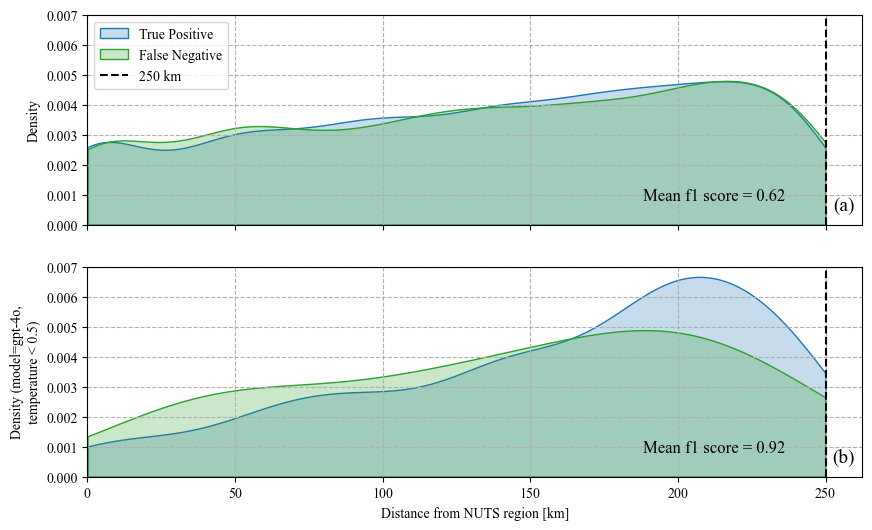

In [42]:
TP = []
FP = []
FN = []

_ = only_level2_250km.apply(populate_all_the_lists, axis=1)

fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)

ax = axs[0]
sns.kdeplot(TP, fill=True, clip=(0, 250), label=f"True Positive", ax=ax) 
sns.kdeplot(FP, fill=True, clip=(0, None), label=f"False Positive", ax=ax)
sns.kdeplot(FN, fill=True, clip=(0, 250), label=f"False Negative", ax=ax)
ax.axvline(250, color="black", label="250 km", linestyle="dashed")
ax.set_xlim(0, None)
ax.set_ylim(0, 0.007)
ax.legend()
ax.grid(linestyle='dashed')
ax.text(0.99, 0.05, "(a)", 
        transform=ax.transAxes,
        fontsize=14,
        ha='right',
        va='bottom')

ax.text(0.9, 0.1, f"Mean f1 score = {round(only_level2_250km.f1.mean(), 2)}", 
        transform=ax.transAxes,
        fontsize=12,
        ha='right',
        va='bottom')

TP = []
FP = []
FN = []

only_gpt4o = only_level2_250km[only_level2_250km["model_str"] == "gpt-4o"]
only_gpt4o = only_gpt4o[only_gpt4o["temperature"] == 0]
_ = only_gpt4o.apply(populate_all_the_lists, axis=1)

ax = axs[1]
sns.kdeplot(TP, fill=True, clip=(0, 250), label=f"True Positive", ax=ax) 
sns.kdeplot(FP, fill=True, clip=(0, None), label=f"False Positive", ax=ax)
sns.kdeplot(FN, fill=True, clip=(0, 250), label=f"False Negative", ax=ax)
ax.axvline(250, color="black", label="250 km", linestyle="dashed")
ax.set_xlim(0, None)
ax.set_ylim(0, 0.007)
ax.grid(linestyle='dashed')
ax.set_xlabel("Distance from NUTS region [km]")
ax.set_ylabel("Density (model=gpt-4o,\ntemperature < 0.5)")
ax.text(0.99, 0.05, "(b)", 
        transform=ax.transAxes,
        fontsize=14,
        ha='right',
        va='bottom')
ax.text(0.9, 0.1, f"Mean f1 score = {round(only_gpt4o.f1.mean(), 2)}", 
        transform=ax.transAxes,
        fontsize=12,
        ha='right',
        va='bottom')

fig.savefig("pics/kde-plots-RAG.png", bbox_inches="tight")

Rising because of more cities
KDE normalized, so even with way less FNs they look the same.
Density is completely simimalr -> distance has no effect on results -> would be weird anyway

# By Question Category (tab:res-rag-cats)

In [45]:
vars = ["question_category"]

table = pd.pivot_table(results, values=["f1", "precision", "recall"], index=vars, aggfunc="mean", sort=False)
table1 = pd.pivot_table(results, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean", sort=False)
table1 = table1[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]

table = table[["f1"]]
table["difference_to_non_rag"] = table["f1"] - table1["f1_non_rag"]

styled = table.style\
                .format("{:.2f}") \
                .highlight_max(subset=["f1", "difference_to_non_rag"], props='font-weight: bold', axis = 0) \
                .background_gradient(subset=["difference_to_non_rag"], cmap="BrBG") \
                .background_gradient(subset=["f1"], cmap="Oranges") \

print(table.to_latex(escape=True, float_format="%.2f",index=True))
styled

\begin{tabular}{lrr}
\toprule
 & f1 & difference\_to\_non\_rag \\
question_category &  &  \\
\midrule
simple topology & 0.53 & 0.03 \\
neighbors & 0.45 & 0.03 \\
directions bool & 0.75 & 0.21 \\
directions open & 0.29 & -0.14 \\
proximity & 0.58 & 0.32 \\
combinations & 0.44 & 0.39 \\
\bottomrule
\end{tabular}



,f1,difference_to_non_rag
question_category,,
simple topology,0.53,0.03
neighbors,0.45,0.03
directions bool,0.75,0.21
directions open,0.29,-0.14
proximity,0.58,0.32
combinations,0.44,0.39


## Only for gpt-4o & temp < 0.5 (tab:res-rag-cats-best)

In [47]:
vars = ["question_category"]

df = results[(results["model_str"] == "gpt-4o") & (results["temperature"] == 0)]

table = pd.pivot_table(df, values=["f1", "precision", "recall"], index=vars, aggfunc="mean", sort=False)
table1 = pd.pivot_table(df, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean", sort=False)
table1 = table1[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]

table = table[["f1"]]
table["difference_to_non_rag"] = table["f1"] - table1["f1_non_rag"]

styled = table.style\
                .format("{:.2f}") \
                .highlight_max(subset=["f1", "difference_to_non_rag"], props='font-weight: bold', axis = 0) \
                .background_gradient(subset=["difference_to_non_rag"], cmap="BrBG") \
                .background_gradient(subset=["f1"], cmap="Oranges") \

print(table.to_latex(escape=True, float_format="%.2f",index=True))
styled

\begin{tabular}{lrr}
\toprule
 & f1 & difference\_to\_non\_rag \\
question_category &  &  \\
\midrule
simple topology & 0.96 & 0.32 \\
neighbors & 0.84 & 0.34 \\
directions bool & 0.99 & 0.52 \\
directions open & 0.41 & -0.10 \\
proximity & 0.89 & 0.56 \\
combinations & 0.72 & 0.64 \\
\bottomrule
\end{tabular}



,f1,difference_to_non_rag
question_category,,
simple topology,0.96,0.32
neighbors,0.84,0.34
directions bool,0.99,0.52
directions open,0.41,-0.10
proximity,0.89,0.56
combinations,0.72,0.64


# All questions (tab:by-question-rag)

In [49]:
vars = ["question_raw"]

table1 = pd.pivot_table(results, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=vars, aggfunc="mean", sort=False)
table1 = table1[["f1_non_rag", "precision_non_rag", "recall_non_rag", "hallucination_rate_nuts"]]

In [50]:
vars = ["question_raw"]
vals = ["f1"]

df = results[results["temperature"] < 0.5]
df = df[df["model_str"] == "gpt-4o"]
table = pd.pivot_table(df, values=vals, index=vars, aggfunc="mean", sort=False)

table["difference_to_non_rag"] = table["f1"] - table1["f1_non_rag"]
vals.append("difference_to_non_rag")
table = table[vals]
styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .background_gradient(subset=["difference_to_non_rag"], cmap="BrBG") \
                .map(lambda x: 'color: black; background-color: transparent' if pd.isnull(x) else '') \
                .highlight_max(subset=vals, props='font-weight: bold', axis = 0)
styled

,f1,difference_to_non_rag
question_raw,,
What are all the NUTS regions that contain the city CITY?,1.00,0.68
What NUTS regions are within the region CODE?,0.91,0.22
Is the NUTS region CODE bordering the region CODE?,0.99,0.25
What regions of the same level are neighbors of the NUTS region CODE?,0.86,0.57
What are the second order neighbors of the same NUTS level for the NUTS region CODE?,0.64,0.40
Is NUTS region CODE DIRECTION of NUTS region CODE?,0.99,0.46
Is the NUTS region CODE DIRECTION of the city of CITY?,0.98,0.43
To which direction is CITY from CITY?,0.39,-0.22
CITY is to which direction of NUTS region CODE?,0.55,0.30


In [51]:
pyperclip.copy(table.to_latex(escape=True, float_format="%.2f",index=True))

# MAPS (fig:map-spatial-rag) -> not in thesis
Not really interesting results. Since the results are based on generated queries, there are no spatial differences.

In [53]:
# Get all cities with more than 20000 inhabitants
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?cityName ?population ?cityWKT
WHERE {
  ?city a gn:Feature ;
        gn:population ?population ;
    	gn:name ?cityName ;
        geo:hasGeometry ?cityGeom .
  ?cityGeom geo:asWKT ?cityWKT .
  FILTER(?population > 20000)
}"""

# get only the cities that were at least 10 times the example

df = sparql_select(q)
df["cityWKT"] = df["cityWKT"].apply(wkt.loads)

In [54]:
all_gdfs1 = []

city_answer = results[results.answer_type == "single_city"]

In [55]:
def temp(df):
    vals = df.values.tolist()
    if len(vals) > 0:
        res = vals[0][0]
    else:
        res = ""
    return res

city_answer["output_city"] = city_answer.gt_results_from_graph_db.apply(temp)

C:\Users\arbeit\AppData\Local\Temp\ipykernel_43384\3183675427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_answer["output_city"] = city_answer.gt_results_from_graph_db.apply(temp)


In [56]:
num_ex = city_answer[["output_city", "precision", "recall", "f1"]].groupby("output_city").size()

In [57]:
mean_quality_values_by_city = city_answer[["output_city", "precision", "recall", "f1"]].groupby("output_city").mean()
idx = num_ex[num_ex>6].index
idx = idx[idx != ""]
idx = idx[idx != "Akrotiri"]
idx = idx[idx != "Tsada - Tremithousa - Tala (Borders)"]
idx

Index(['Athens', 'Augsburg', 'Barcelona', 'Berlin', 'Brugge', 'Brussels',
       'Bucharest', 'Budapest', 'Cluj-Napoca', 'Copenhagen', 'Dresden',
       'Dublin', 'Győr', 'Hamburg', 'Istanbul', 'Kraków', 'Kyiv', 'Köln',
       'Las Palmas de Gran Canaria', 'Leipzig', 'London', 'Lyon', 'Madrid',
       'Mannheim', 'Milan', 'Minsk', 'Munich', 'Nantes', 'Naples', 'Paris',
       'Prague', 'Rennes', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm',
       'Toulouse', 'Vienna', 'Vilnius', 'Warsaw', 'Zagreb', 'Zaragoza',
       'İzmir', 'Łódź', 'Žilina'],
      dtype='object', name='output_city')

In [58]:
example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="cityName")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="cityWKT", crs=3035)

gdf['marker_size'] = gdf['population'] / gdf['population'].max() * 250
all_gdfs1.append(gdf)

### All cities as examples

In [60]:
results.loc[:, "has_city_input"] = results["inputs"].apply(lambda x: "CITY" in x.keys())
with_city = results[results["has_city_input"]]
with_city.loc[:, "input_city"] = with_city["inputs"].apply(lambda x: x["CITY"] if type(x["CITY"])==str else x["CITY"][0])

C:\Users\arbeit\AppData\Local\Temp\ipykernel_43384\3990714576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_city.loc[:, "input_city"] = with_city["inputs"].apply(lambda x: x["CITY"] if type(x["CITY"])==str else x["CITY"][0])


In [61]:
num_ex = with_city[["input_city", "precision", "recall", "f1"]].groupby("input_city").size()
mean_quality_values_by_city = with_city[["input_city", "precision", "recall", "f1"]].groupby("input_city").mean()
idx = num_ex[num_ex>6].index
idx = idx[idx != ""]
idx = idx[idx != "Akrotiri"]
idx = idx[idx != "Tsada - Tremithousa - Tala (Borders)"]

example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="cityName")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="cityWKT", crs=3035)

gdf['marker_size'] = gdf['population'] / gdf['population'].max() * 400
all_gdfs1.append(gdf)

In [62]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 12))
# for gdf, ax in zip(all_gdfs1, axs):
#     norm = mcolors.Normalize(vmin=0, vmax=1)
#     cmap = plt.cm.magma
    
#     gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['f1']], markersize=gdf["marker_size"], edgecolor="black")
#     ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)
    
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
    
#     cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.03])
#     cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean F1 Score', orientation = 'horizontal')
    
#     ax.axis("off")

# plt.tight_layout()

In [63]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

for gdf in all_gdfs1:
    print(pearsonr(gdf.f1, gdf.population))

PearsonRResult(statistic=-0.04973218894745071, pvalue=0.7427448536420915)
PearsonRResult(statistic=-0.10800365216992698, pvalue=0.25058821854742996)


### NUTS

In [65]:
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

SELECT ?city ?notation ?codeWKT
WHERE {
  ?code a skos:Concept ;
    	skos:notation ?notation ;
        geo:hasGeometry ?codeGeom .
  ?codeGeom geo:asWKT ?codeWKT .
}"""

# get only the cities that were at least 10 times the example

df = sparql_select(q)
df["codeWKT"] = df["codeWKT"].apply(wkt.loads)

In [66]:
all_gdfs = []
level = 2

results.loc[:, "has_input_codes"] = results["inputs"].apply(lambda x: "CODE" in x.keys())
with_code = results[results["has_input_codes"]]
with_code.loc[:, "input_code"] = with_code["inputs"].apply(lambda x: x["CODE"] if type(x["CODE"])==str else x["CODE"][0])
with_code = with_code[with_code["NUTS level"]==level]

C:\Users\arbeit\AppData\Local\Temp\ipykernel_43384\2042331774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_code.loc[:, "input_code"] = with_code["inputs"].apply(lambda x: x["CODE"] if type(x["CODE"])==str else x["CODE"][0])


In [67]:
num_ex = with_code[["input_code", "precision", "recall", "f1"]].groupby("input_code").size()
mean_quality_values_by_city = with_code[["input_code", "precision", "recall", "f1"]].groupby("input_code").mean()
idx = num_ex[num_ex>6].index

In [68]:
example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="notation")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="codeWKT", crs=3035)
all_gdfs.append(gdf)

In [69]:
code_as_result = results[results["answer_type"] == "code_iri"]
code_as_result = code_as_result[[type(x) == pd.DataFrame for x in code_as_result["gt_results_from_graph_db"]]]
code_as_result["gt_results_codes"] = code_as_result["gt_results_from_graph_db"].apply(lambda x: x.values.tolist())
code_as_result = code_as_result.explode("gt_results_codes")
code_as_result["gt_results_codes"] = code_as_result["gt_results_codes"].apply(lambda x: x[0].split("/")[-1] if type(x) == list else None)

In [70]:
num_ex = code_as_result[["gt_results_codes", "precision", "recall", "f1"]].groupby("gt_results_codes").size()
mean_quality_values_by_city = code_as_result[["gt_results_codes", "precision", "recall", "f1"]].groupby("gt_results_codes").mean()
idx = num_ex[num_ex>6].index

In [71]:
example_cities_with_geoms = mean_quality_values_by_city.loc[idx, :].merge(df, how="left", left_index=True, right_on="notation")
gdf = gpd.GeoDataFrame(example_cities_with_geoms, geometry="codeWKT", crs=3035)
gdf = gdf[[len(x) == 4 for x in gdf.notation]]
all_gdfs.append(gdf)

# Map for RAG experiment. Not in thesis -> not interesting enough

C:\Users\arbeit\AppData\Local\Temp\ipykernel_43384\1102466450.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


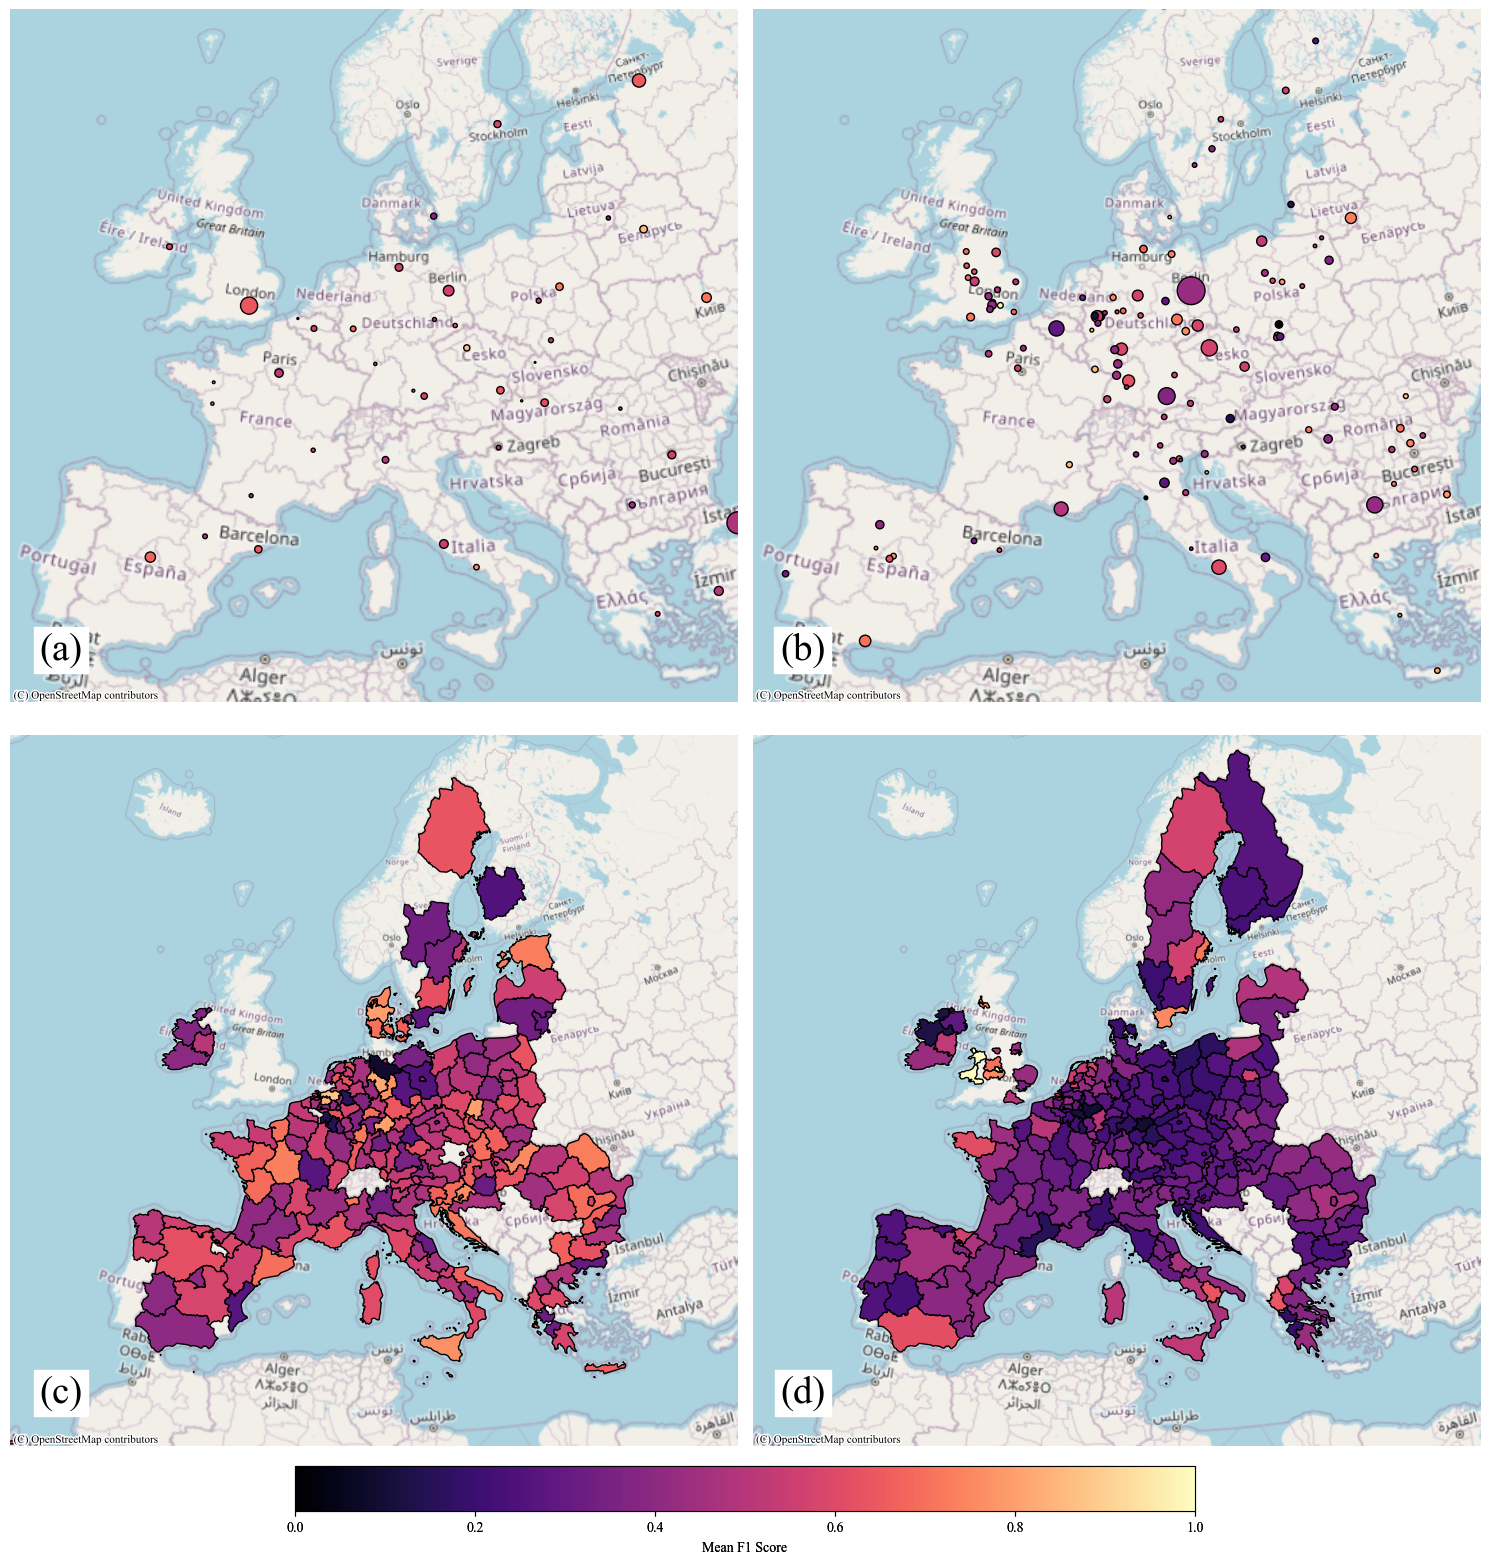

In [73]:
letters = ["a", "b", "c", "d"]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for gdf, ax in zip(all_gdfs1, axes[0]):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.magma
    
    gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['f1']], markersize=gdf["marker_size"], edgecolor="black")
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.03])
    # cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean F1 Score', orientation = 'horizontal')
    ax.set_xlim(2504173.807828995, 5901144.183018832)
    ax.set_ylim(1352828.6899153944, 4587174.789333616)
    ax.axis("off")
    t = ax.text(0.1, 0.05, f"({letters.pop(0)})", 
            transform=ax.transAxes,
            fontsize=28,
            fontdict={'family': 'Times New Roman'},
            ha='right',
            va='bottom')
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor="white"))
    
for ax, gdf in zip(axes[1], all_gdfs):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.magma
    
    gdf.plot(ax=ax, color=[cmap(norm(value)) for value in gdf['f1']], edgecolor="black")
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar_ax = fig.add_axes([0.2, -0.025, 0.6, 0.03])
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Mean F1 Score', orientation = 'horizontal')
    ax.set_xlim(2000000, 6500000)
    ax.set_ylim(1000000, 5400000)
    ax.axis("off")
    t = ax.text(0.1, 0.05, f"({letters.pop(0)})", 
        transform=ax.transAxes,
        fontsize=28,
        fontdict={'family': 'Times New Roman'},
        ha='right',
        va='bottom')
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor="white"))

plt.tight_layout()
fig.savefig("pics/accuracy_by_city_and_nuts_RAG.png", bbox_inches="tight")

# The fine-tuned dataset is now included again
Since it is not a comparison anymore

In [75]:
results = results_with_fine

# Sankey Diagram for Diagnostics (fig:sankey)

In [77]:
df = copy.deepcopy(results)
# df = df[df["temperature"] < 0.5]
# df = df[df["model_str"] == "gpt-4o"]

per_sucess_level = df.groupby("success_level").size()



not_executed_rows = ["TIMEOUT", "no_sparql_to_try", "python_error_from_sparql_select", "query_failed"]
definetely_semantic_errors = ["gt_empty_answer_not", "mixed_colum", "no_correct_type", "generated_city_iri"]
all_the_rest_columns = ["correct_answer_type_in_df", "correct_answer_type_in_df_but_code", "correct_answer_type_in_df_but_pref_label"]

not_executed_rows = [x for x in not_executed_rows if x in per_sucess_level.index]
definetely_semantic_errors = [x for x in definetely_semantic_errors if x in per_sucess_level.index]
all_the_rest_columns = [x for x in all_the_rest_columns if x in per_sucess_level.index]

not_executed = [per_sucess_level[row] for row in not_executed_rows]
timeout = per_sucess_level["TIMEOUT"]

executed_rows = set(per_sucess_level.index) - set(not_executed_rows)
executed = [per_sucess_level[row] for row in executed_rows]

empty_result = per_sucess_level["empty_but_not_supposed_to_be"] 

df_promising = df[df["success_level"].apply(lambda x: x in all_the_rest_columns)]
semantic_errors2 = len(df_promising[df_promising.f1 == 0])
semantic_errors1 = [per_sucess_level[row] for row in definetely_semantic_errors]

partly_correct = len(df_promising[(df_promising.f1 > 0) & (df_promising.f1 < 1)])
completely_correct = len(df_promising[df_promising.f1 == 1])

got_results = sum(semantic_errors1) + semantic_errors2 + partly_correct + completely_correct

print("Executed: ", sum(executed))
print("Not Executed: ", sum(not_executed), "\n")

print("Timeout: ", timeout)
print("Invalid syntax: ", sum(not_executed) - timeout, "\n")

print("Empty Result: ", empty_result)
print("Got results: ", got_results, "\n")
print("Both Empty: ",  per_sucess_level["both_empty"])

print("Not suppost to be empty: (Semantic errors)", per_sucess_level["empty_but_not_supposed_to_be"], "\n")

print("Semantic Errors: ", sum(semantic_errors1) +  semantic_errors2)

print("Partly Correct: ", partly_correct)
print("Completely Correct: ", completely_correct)



Executed:  21750
Not Executed:  6918 

Timeout:  245
Invalid syntax:  6673 

Empty Result:  4019
Got results:  16909 

Both Empty:  822
Not suppost to be empty: (Semantic errors) 4019 

Semantic Errors:  1890
Partly Correct:  1921
Completely Correct:  13098


In [78]:
len(results) 

28668

In [79]:
sankey_string = f"""
Generated Query [{sum(not_executed)}] Query not executed
Generated Query [{sum(executed)}] Query executed

Query not executed [{timeout}] Timeout
Query not executed [{sum(not_executed) - timeout}] Invalid syntax

Query executed [{empty_result}] Empty result
Query executed [{got_results}] Got results

Query executed [{per_sucess_level["both_empty"]}] Both Empty
Empty result [{per_sucess_level["empty_but_not_supposed_to_be"]}] Semantic errors without result

Got results [{sum(semantic_errors1) + semantic_errors2}] Semantic errors with result
Got results [{partly_correct}] Partly correct
Got results [{completely_correct}] Completely correct"""
print(sankey_string)


Generated Query [6918] Query not executed
Generated Query [21750] Query executed

Query not executed [245] Timeout
Query not executed [6673] Invalid syntax

Query executed [4019] Empty result
Query executed [16909] Got results

Query executed [822] Both Empty
Empty result [4019] Semantic errors without result

Got results [1890] Semantic errors with result
Got results [1921] Partly correct
Got results [13098] Completely correct


# Analysing only executable queries (section results RQ2 - Reasons for Failure)

In [81]:
only_executed = results[results['results_from_graph_db'].apply(lambda x: type(x) == pd.DataFrame)]

In [82]:
table = only_executed[["model_str", "ontology", "template", "temperature", "f1"]]
table = table.groupby(["model_str", "ontology", "template", "temperature"]).mean()

styled = table.style\
                .format("{:.2f}") \
                .background_gradient(subset=["f1"], cmap="Oranges") \
                .highlight_max(subset=["f1"], props='font-weight: bold', axis = 0)
styled

In [83]:
only_executed[only_executed.model_str == "gpt-4o"].f1.mean()

0.842354316147341

In [84]:
test = results[results.temperature < 1]
sucessfull = test[test.success_rate]
sucessfull.f1.mean()

0.8924001409628051

In [85]:
sucessfull.groupby("question_raw", sort=False).f1.mean()

question_raw
What NUTS regions are within the region CODE?                                                     0.956240
Is the NUTS region CODE bordering the region CODE?                                                0.994056
Is NUTS region CODE DIRECTION of NUTS region CODE?                                                0.989570
Is the NUTS region CODE DIRECTION of the city of CITY?                                            0.970052
Is CITY within SMALLDISTANCE km of the NUTS region CODE?                                          0.995607
What NUTS regions share a border with the region CODE in the DIRECTION on the same nuts level?    0.844151
What are all the NUTS regions that contain the city CITY?                                         0.961744
What are the second order neighbors of the same NUTS level for the NUTS region CODE?              0.587941
To which direction is CITY from CITY?                                                             0.487414
CITY is to which directi